In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ahmed\.cache\kagglehub\datasets\rashikrahmanpritom\plant-disease-recognition-dataset\versions\1


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import cv2

In [24]:
train_path = '/kaggle/input/plant-disease-recognition-dataset/Train/Train'
test_path = '/kaggle/input/plant-disease-recognition-dataset/Test/Test'
val_path = '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation'

In [25]:
def loadingData(DSpath, imagesize =(224, 224)):
    imgs, lbls = [], []
    for cls in sorted(os.listdir(DSpath)):
        clspath = os.path.join(DSpath, cls)
        if not os.path.isdir(clspath): continue
        for imgnm in os.listdir(clspath):
            img = cv2.imread(os.path.join(clspath,imgnm))
            if img is not None:
                imgs.append(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), imagesize))
                lbls.append(cls)

    return np.array(imgs), np.array(lbls)

In [26]:
def count_images_in_folder(folder_path):
    total = 0
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            total += len(os.listdir(class_folder))
    return total


train_count = count_images_in_folder(path + '/Train/Train')
val_count = count_images_in_folder(path + '/Validation/Validation')
test_count = count_images_in_folder(path + '/Test/Test')

print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")


Train images: 1322
Validation images: 60
Test images: 150


In [27]:
for class_name in os.listdir(path + '/Train/Train'):
    class_folder = os.path.join(path + '/Train/Train', class_name)
    files = os.listdir(class_folder)
    print(f"{class_name}: {len(files)} images")


Healthy: 458 images
Powdery: 430 images
Rust: 434 images


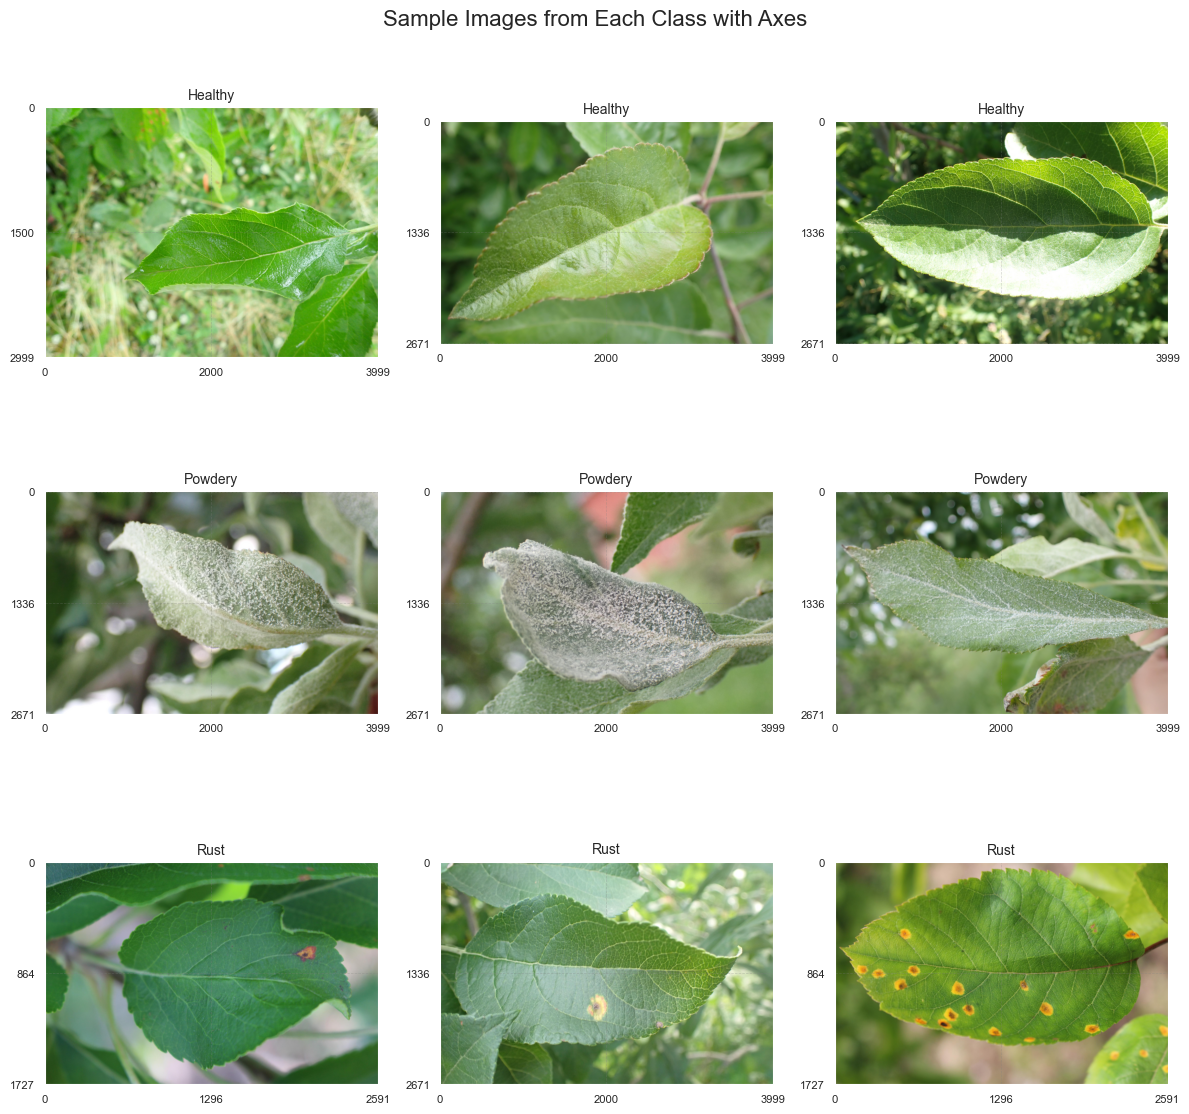

In [28]:
def show_sample_images_with_axes(data_path, classes, image_per_class=2):
    fig, axs = plt.subplots(len(classes), image_per_class, figsize=(image_per_class * 4, len(classes) * 4))

    if len(classes) == 1:
        axs = [axs]  # handle when there is only one class
    elif image_per_class == 1:
        axs = [[ax] for ax in axs]  # handle 1 column

    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        images = os.listdir(class_folder)[:image_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_folder, img_name)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            ax = axs[i][j]
            ax.imshow(img)
            ax.set_title(f"{class_name}", fontsize=10)
            ax.set_xticks([0, img.shape[1] // 2, img.shape[1] - 1])
            ax.set_yticks([0, img.shape[0] // 2, img.shape[0] - 1])
            ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=8)

    plt.suptitle("Sample Images from Each Class with Axes", fontsize=16)
    plt.tight_layout()
    plt.show()


show_sample_images_with_axes(path + '/Train/Train', ['Healthy', 'Powdery', 'Rust'], image_per_class=3)


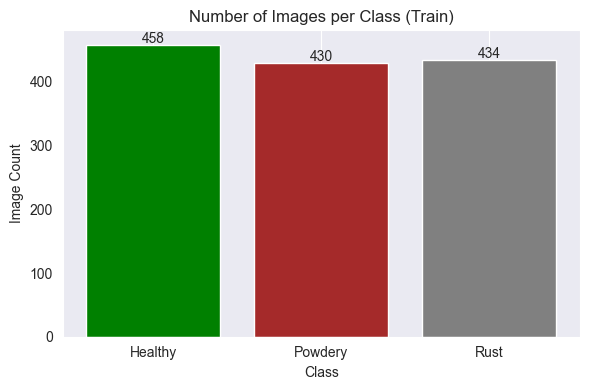

In [31]:
class_counts = {}
for class_name in os.listdir(path + '/Train/Train'):
    class_folder = os.path.join(path + '/Train/Train', class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(6, 4))
plt.bar(classes, counts, color=['green', 'brown', 'grey'])
plt.title('Number of Images per Class (Train)')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.grid(axis='y')

for i in range(len(classes)):
    plt.text(i, counts[i] + 3, str(counts[i]), ha='center')

plt.tight_layout()
plt.show()


In [34]:
from sklearn.preprocessing import LabelEncoder

x_train_origin, y_train = loadingData(path + '/Train/Train')
x_val_origin, y_val = loadingData(path + '/Validation/Validation')
x_test_origin, y_test = loadingData(path + '/Test/Test')

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)


In [35]:
num_classes = len(np.unique(y_train_encoded))
print(f"{num_classes} unique classes in data.")

3 unique classes in data.


In [36]:
print("Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes mapping: {np.str_('Healthy'): np.int64(0), np.str_('Powdery'): np.int64(1), np.str_('Rust'): np.int64(2)}


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Define your model
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

C:\Users\ahmed\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
from tensorflow.keras.optimizers import Adam
model_CNN.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_cnn_train = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = datagen_cnn_train.flow(x_train_origin, y_train_encoded, batch_size=64, shuffle=True)
datagen_cnn_val = ImageDataGenerator(rescale=1.0 / 255.0)
val_generator = datagen_cnn_val.flow(x_val_origin, y_val_encoded, batch_size=64, shuffle=False)

In [41]:
history = model_CNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


C:\Users\ahmed\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7360 - loss: 7.0029 - val_accuracy: 0.3333 - val_loss: 11.8749
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8797 - loss: 1.6119 - val_accuracy: 0.3333 - val_loss: 12.5840
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9221 - loss: 0.8406 - val_accuracy: 0.3833 - val_loss: 5.2441
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9516 - loss: 0.4213 - val_accuracy: 0.3500 - val_loss: 9.6083
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9546 - loss: 0.3454 - val_accuracy: 0.3333 - val_loss: 35.5847
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9523 - loss: 0.4179 - val_accuracy: 0.3333 - val_loss: 19.5962
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9637 - loss: 0.2363 - val_accuracy: 0.3500 - val_loss: 10.3633
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9682 - loss: 0.2303 - val_accuracy: 0.5000 - val_loss: 6.519

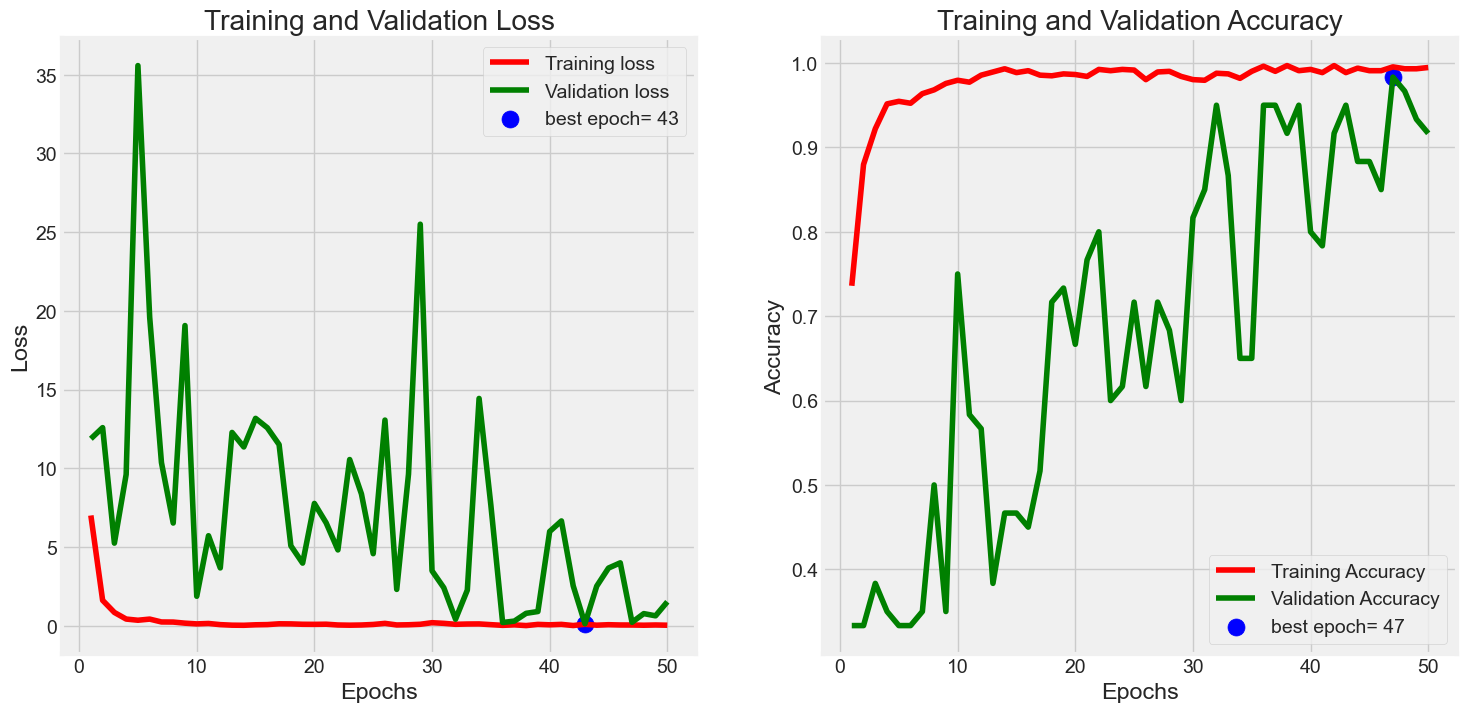

In [43]:
trr_acc = history.history['accuracy']
trr_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest_loss = val_loss[index_loss]

index_acc = np.argmax(val_acc)
vall_highest_acc = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(trr_acc))]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(18, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, trr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest_loss, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, trr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, vall_highest_acc, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


C:\Users\ahmed\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


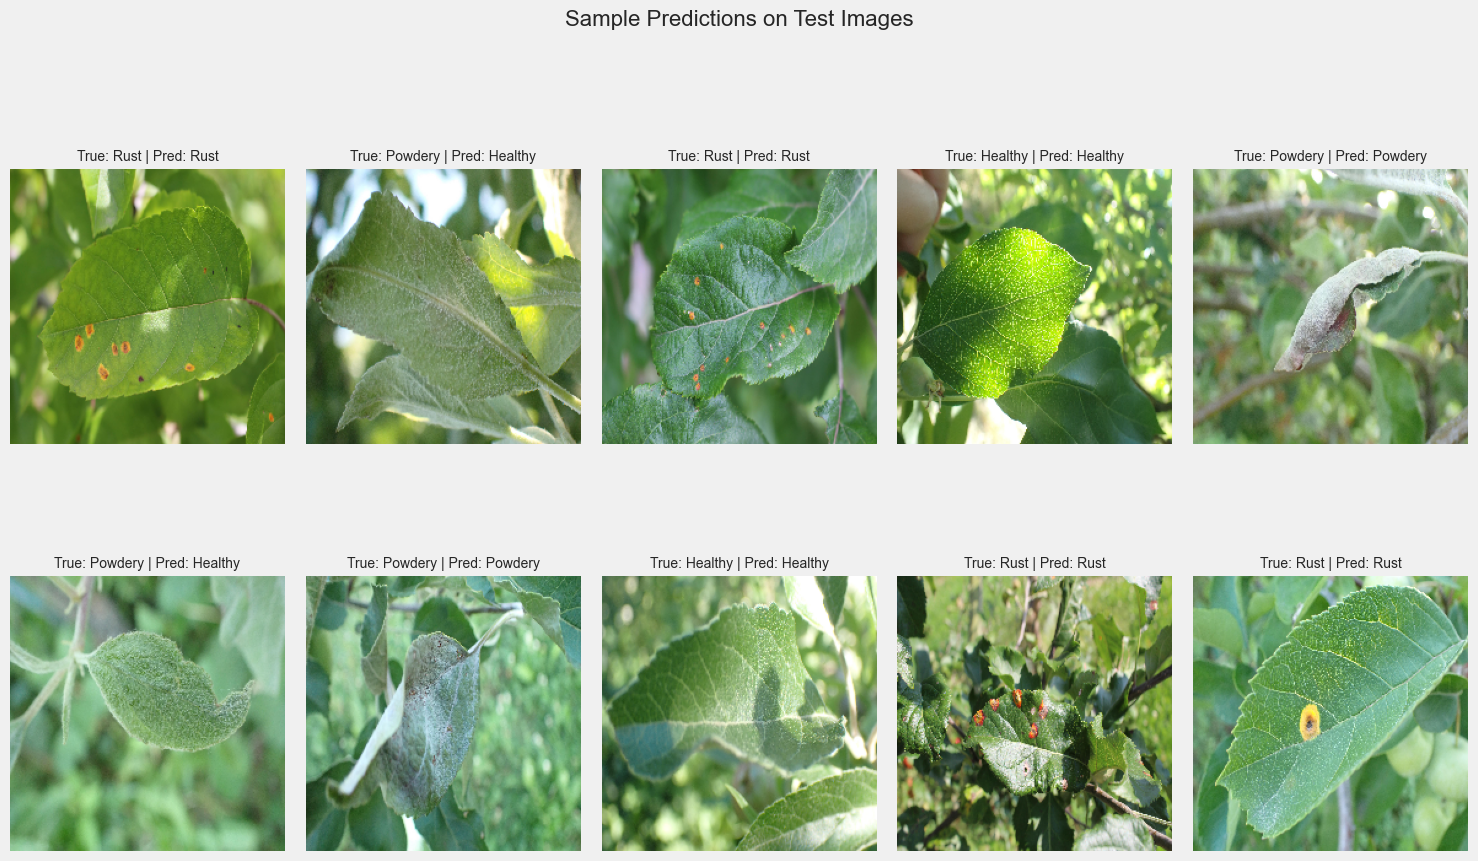

In [45]:
num_samples = 10

indices = np.random.choice(len(x_test_origin), num_samples, replace=False)

# Predict on test data
datagen_test = ImageDataGenerator(rescale=1.0 / 255.0)
y_pred = model_CNN.predict(datagen_test.flow(x_test_origin, batch_size=32, shuffle=False))
y_pred_classes = np.argmax(y_pred, axis=1)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img = x_test_origin[idx]
    true_label = y_test_encoded[idx]
    pred_label = y_pred_classes[idx]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    true_name = le.inverse_transform([true_label])[0]
    pred_name = le.inverse_transform([pred_label])[0]
    plt.title(f"True: {true_name} | Pred: {pred_name}", fontsize=10)

plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.tight_layout()
plt.show()


In [46]:
model_CNN.save('model.h5')
